# Covid-19 Death prediction

### 1. Data Cleaning

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression,Lasso
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

import prince
import mca

In [2]:
PatientAll = pd.read_csv("COVID19MEXICO2020.csv")

/var/folders/l3/pvwqxhyx7cg3bg4pv2tf_42c0000gp/T/ipykernel_14938/419699222.py:1: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  PatientAll = pd.read_csv("COVID19MEXICO2020.csv")


In [3]:
filtered_df = PatientAll[PatientAll['CLASIFICACION_FINAL'] <= 3]
covidPatient = filtered_df.head(5000)
covidPatient.to_csv('filtered_dataset.csv', index=False)

In [4]:
covidPatient.head(6)

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2021-10-31,z4d6fe,1,6,24,1,24,24,28,1,...,2,1,1,2,97,3,99,México,97,97
3,2021-10-31,z3bf80,2,12,8,2,8,8,37,1,...,2,1,1,2,97,3,99,México,97,97
15,2021-10-31,z54912,1,12,31,1,31,31,79,1,...,2,1,1,2,97,3,99,México,97,97
18,2021-10-31,z552ac,1,12,1,1,9,1,1,1,...,2,1,1,2,97,3,99,México,97,97
20,2021-10-31,z59345,1,12,31,2,31,31,89,1,...,2,1,1,2,97,3,99,México,97,97
23,2021-10-31,z4887b,2,12,8,1,10,8,37,1,...,1,1,1,2,97,3,99,México,97,97


In [5]:
U_mexicoPatient = covidPatient

In [6]:
U_mexicoPatient.columns

Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA',
       'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA',
       'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'TOMA_MUESTRA_LAB', 'RESULTADO_LAB',
       'TOMA_MUESTRA_ANTIGENO', 'RESULTADO_ANTIGENO', 'CLASIFICACION_FINAL',
       'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'UCI'],
      dtype='object')

In [7]:
## translation the column from spanish to English
U_mexicoPatient.columns = ['UPDATE_DATE', 'RECORD_ID', 'ORIGIN', 'MEDICAL_UNIT', 'ENTITY_UM',
       'SEX', 'ENTITY_NAC', 'ENTITY_RES', 'MUNICIPALITY_RES', 'PATIENT_TYPE',
       'ADMISSION_DATE', 'SYMPTOM_DATE', 'DATE_DIED', 'INTUBATED', 'PNEUMONIA',
       'AGE', 'NATIONALITY', 'PREGNANCY', 'INDIGENOUS_LANGUAGE_SPEAKER', 'INDIGENOUS',
       'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HYPERTENSION', 'OTHER_COM',
       'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'SMOKING',
       'OTHER_CASE', 'LAB_SAMPLE_TAKING', 'LAB_RESULT',
       'ANTIGEN_SAMPLE_TAKE', 'ANTIGEN_RESULT', 'CLASSIFICATION',
       'MIGRANT', 'COUNTRY_NATIONALITY', 'COUNTRY_OF_ORIGIN', 'ICU']

In [8]:
## select the useful columns
mexicoPatient = U_mexicoPatient[["SEX", "AGE", "CLASSIFICATION", "PATIENT_TYPE", "PNEUMONIA", "PREGNANCY", "DIABETES", 'COPD', 'ASTHMA', "INMSUPR" ,"HYPERTENSION", "CARDIOVASCULAR", "RENAL_CHRONIC", "OTHER_COM", "OBESITY", "SMOKING", "ORIGIN", "MEDICAL_UNIT", "INTUBATED", "ICU", "DATE_DIED"]]

In [9]:
## replace all the missing value that indicate using numbers 97,98,99 to nan
mexicoPatient= mexicoPatient.replace(97, np.nan)
mexicoPatient= mexicoPatient.replace(98, np.nan)
mexicoPatient= mexicoPatient.replace(99, np.nan)
mexicoPatient["AGE"] = covidPatient["AGE"]

In [10]:
columns_to_replace = mexicoPatient.columns.difference(['AGE', 'CLASSIFICATION', 'MEDICAL_UNIT', 'PATIENT_TYPE', 'DATE_DIED', 'SEX','ORIGIN'])
mexicoPatient[columns_to_replace] = mexicoPatient[columns_to_replace].replace({1: 'Y', 2: 'N'})
mexicoPatient['PATIENT_TYPE'] = mexicoPatient['PATIENT_TYPE'].replace({1: 'home', 2: 'hospital'})
mexicoPatient['SEX'] = mexicoPatient['SEX'].replace({1: 'F', 2: 'M'})

In [11]:
age_bins = [0, 30, 40, 50, 60, 100]  
age_labels = ['0-30', '31-40', '41-50', '51-60', '61+']

# Create a new column based on the binning
mexicoPatient['AGE'] = pd.cut(mexicoPatient['AGE'], bins=age_bins, labels=age_labels, right=False)

In [12]:
## change the Data of Died to a Catogoty variable Died
mexicoPatient['DATE_DIED'] = mexicoPatient['DATE_DIED'].apply(lambda x: 'alive' if x == '9999-99-99' else "died")
mexicoPatient.rename(columns = {"DATE_DIED": "STATUS"}, inplace=True)

In [13]:
mexicoPatient.head(6)

,SEX,AGE,CLASSIFICATION,PATIENT_TYPE,PNEUMONIA,PREGNANCY,DIABETES,COPD,ASTHMA,INMSUPR,...,CARDIOVASCULAR,RENAL_CHRONIC,OTHER_COM,OBESITY,SMOKING,ORIGIN,MEDICAL_UNIT,INTUBATED,ICU,STATUS
0,F,51-60,3,home,N,N,Y,N,N,N,...,N,N,N,N,N,1,6,NaN,NaN,alive
3,M,31-40,3,home,N,NaN,N,N,N,N,...,N,N,N,N,N,2,12,NaN,NaN,alive
15,F,51-60,3,home,N,N,Y,N,N,N,...,N,N,N,N,N,1,12,NaN,NaN,alive
18,F,51-60,3,home,N,N,Y,N,N,N,...,N,N,N,N,N,1,12,NaN,NaN,alive
20,M,31-40,3,home,N,NaN,N,N,N,N,...,N,N,N,N,N,1,12,NaN,NaN,alive
23,F,61+,3,home,N,N,N,N,N,N,...,N,N,N,N,N,2,12,NaN,NaN,alive


In [14]:
mexicoPatient.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 59033
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   SEX             5000 non-null   object  
 1   AGE             5000 non-null   category
 2   CLASSIFICATION  5000 non-null   int64   
 3   PATIENT_TYPE    5000 non-null   object  
 4   PNEUMONIA       4997 non-null   object  
 5   PREGNANCY       2141 non-null   object  
 6   DIABETES        4987 non-null   object  
 7   COPD            4988 non-null   object  
 8   ASTHMA          4987 non-null   object  
 9   INMSUPR         4985 non-null   object  
 10  HYPERTENSION    4987 non-null   object  
 11  CARDIOVASCULAR  4986 non-null   object  
 12  RENAL_CHRONIC   4984 non-null   object  
 13  OTHER_COM       4980 non-null   object  
 14  OBESITY         4990 non-null   object  
 15  SMOKING         4985 non-null   object  
 16  ORIGIN          5000 non-null   int64   
 17  MEDICAL_UNIT 

In [15]:
#Death rate
mexicoPatient["STATUS"].value_counts().get('died',0)/10000

0.0787

/var/folders/l3/pvwqxhyx7cg3bg4pv2tf_42c0000gp/T/ipykernel_14869/3672117033.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


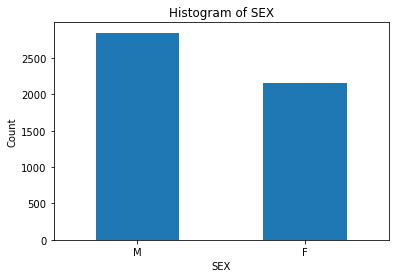

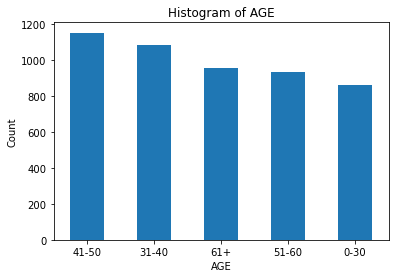

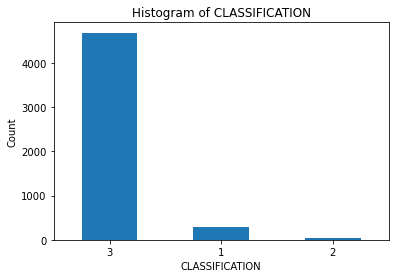

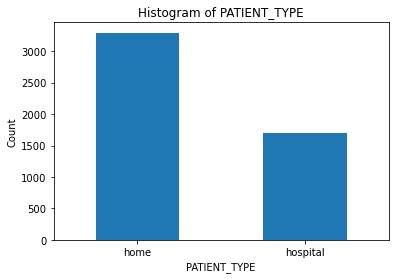

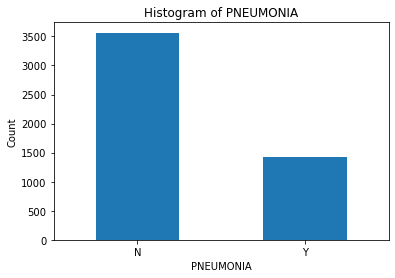

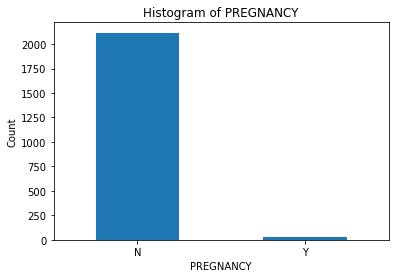

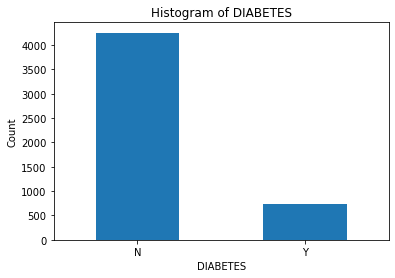

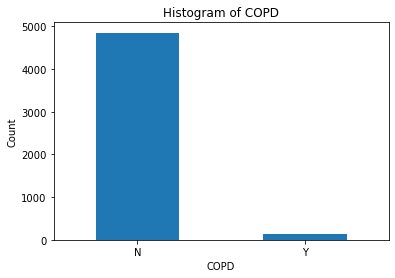

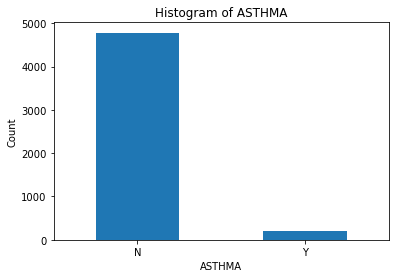

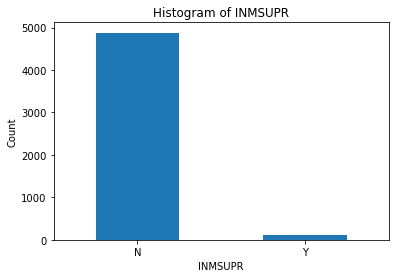

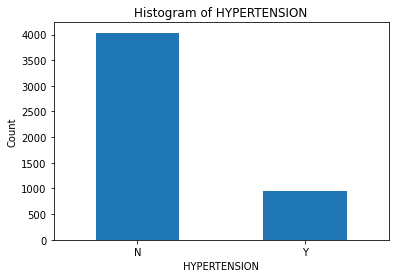

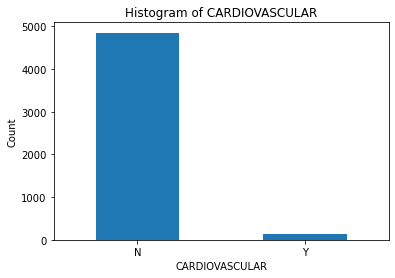

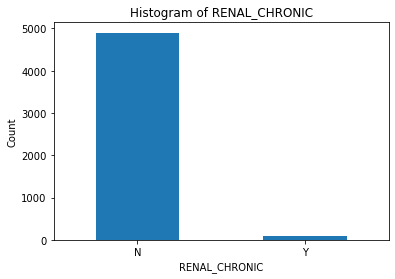

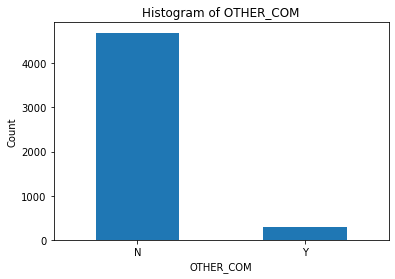

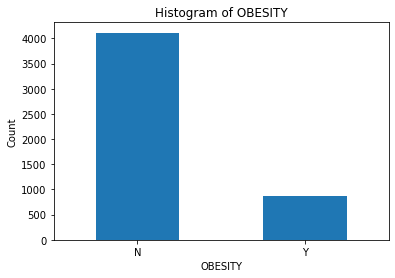

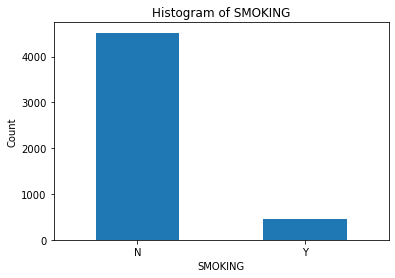

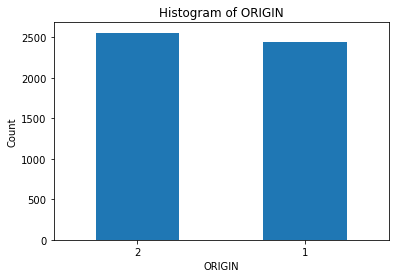

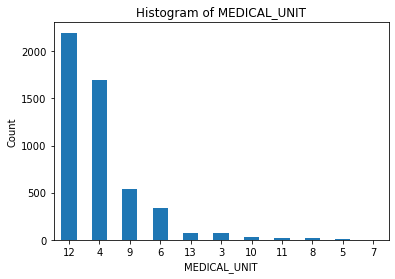

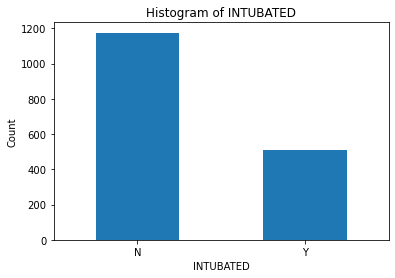

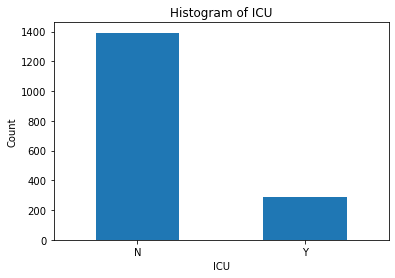

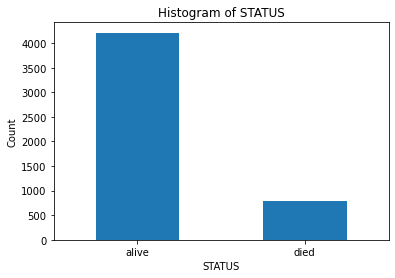

In [16]:
for column in mexicoPatient.columns:
    plt.figure()
    counts = mexicoPatient[column].value_counts()
    counts.plot(kind='bar', rot=0)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Histogram of {column}')

plt.show()

### About Dataset
The dataset was provided by the Mexican government (https://www.gob.mx/salud/documentos/datos-abiertos-bases-historicas-direccion-general-de-epidemiologia). This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 40 unique features and 4 million unique patients. Since we are focusing on COVID-19 patients, we have filtered the individuals diagnosed with COVID-19, specifically those with a classification value less than or equal to 3. After cleaning, the dataset contains 21 unique features and 10,000 unique patient records. (We have removed certain variables such as ID, Country, and Language. The information for the remaining 21 features is listed below.

- sex: female / male.
- age: of the patient.
- classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
- patient type: type of care the patient received in the unit. 'home' for returned home and 'hospital' for hospitalization.
- pneumonia: whether the patient already have air sacs inflammation or not.
- pregnancy: whether the patient is pregnant or not.
- diabetes: whether the patient has diabetes or not.
- copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
- asthma: whether the patient has asthma or not.
- inmsupr: whether the patient is immunosuppressed or not.
- hypertension: whether the patient has hypertension or not.
- cardiovascular: whether the patient has heart or blood vessels related disease.
- renal chronic: whether the patient has chronic renal disease or not.
- other disease (OTHER_COM): whether the patient has other disease or not.
- obesity: whether the patient is obese or not.
- smoking: whether the patient is a tobacco user.
- origin: Indicates whether the patient treated medical units of the first, second or third level.
- medical unit: type of institution of the National Health System that provided the care.
- intubed: whether the patient was connected to the ventilator.
- icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
- status: whether the patient died in 2020.

In [17]:
#Multiple Correspondence Analysis

dataset = mexicoPatient
dataset.columns = ["SEX", "AGE", "CLASSIFICATION", "PATIENT_TYPE", "PNEUMONIA", "PREGNANCY",
                    "DIABETES", "COPD", "ASTHMA", "INMSUPR", "HYPERTENSION", "CARDIOVASCULAR",
                    "RENAL_CHRONIC", "OTHER_COM", "OBESITY", "SMOKING", "ORIGIN", "MEDICAL_UNIT",
                    "INTUBATED", "ICU", "STATUS"]
mca = prince.MCA(
    n_components=2,
    n_iter=2,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca = mca.fit(dataset)
one_hot = pd.get_dummies(dataset)

mca_no_one_hot = prince.MCA(one_hot=False)
mca_no_one_hot = mca_no_one_hot.fit(one_hot)
mca.eigenvalues_summary
mca.row_coordinates(dataset).head()
mca.plot(
    dataset,
    x_component=0,
    y_component=1,
    show_column_markers=True,
    show_row_markers=True,
    show_column_labels=False,
    show_row_labels=False
)


alt.LayerChart(...)

In [16]:
mca.column_contributions_.head().style.format('{:.0%}')
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.211,11.41%,11.41%
1,0.084,4.51%,15.92%
